In [21]:
import numpy as np
import os
import sys
import torch
from matplotlib import image
import matplotlib.pyplot as plt
import numpy.fft as F
from importlib import reload
# sys.path.append('/Users/leonardohuang/Desktop/msu_research/code/')
import utils
from utils import mask_naiveRand,kplot
from sigpy.mri.app import TotalVariationRecon

### Use greedy algorithm to select masks for pre-training CNN
- limited success due to extremely slow execution of the greedy algo.

In [3]:
data_path = '/home/huangz78/data/'
data = np.load(data_path+'data_gt.npz')
print(data.files)
imgdata = np.transpose(data['imgdata'],axes=(2,0,1))
print(imgdata.shape)

['imgdata']
(199, 320, 320)


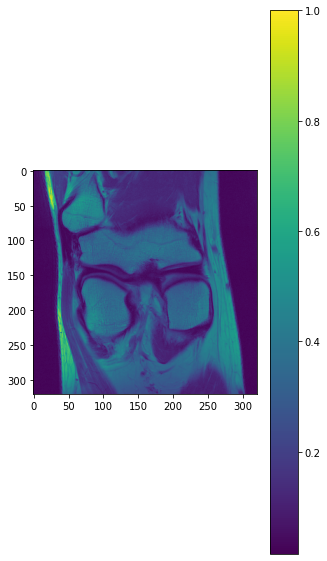

/home/huangz78/mri/utils.py:100: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(np.abs(y)),cmap=cmap)


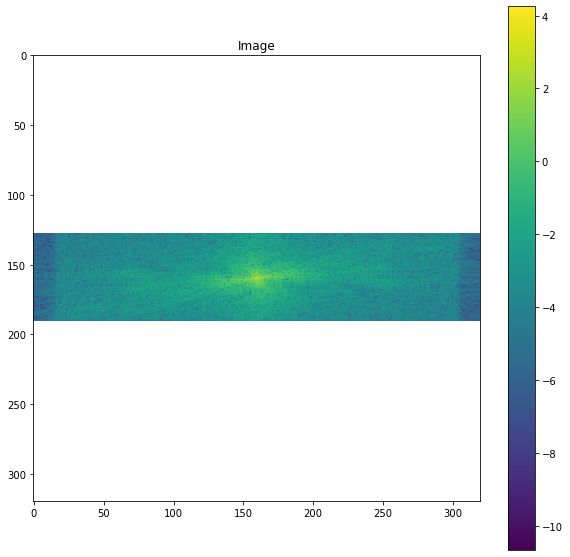

In [15]:
imgind = 8
img = imgdata[imgind,:,:]/np.max(imgdata[imgind,:,:])
heg,wid = img.shape[0],img.shape[1]
roll_flag = True
mask,_,_ = mask_naiveRand(heg,fix=int(heg*.2),other=0,roll=roll_flag)
mask = mask.numpy()
yraw = F.fftshift(F.fftn(img,axes=(0,1),norm='ortho'))
y    = np.zeros_like(yraw)
y[mask==1,:]= yraw[mask==1,:]

plt.figure(figsize=(5,10))
plt.imshow(img)
plt.colorbar()
plt.show()

kplot(y,log=True)

In [8]:
reload(utils)
from utils import mask_naiveRand

In [9]:
from sigpy.mri.app import L1WaveletRecon
from sigpy.mri.app import TotalVariationRecon

- Question: what is the correct input format to use L1WaveletRecon?

    -- ksp roll? assumption: lowest frequency centered
    
    -- mask roll? assumption: lowest frequency centered

### Before running greedy algorithm, want to find out what is the best parameter setting for reconstruction optimization problem
- power of 10 for $\lambda$
    - L1Wavelet: -9,-8.5; 
    - TV: -6.5,-6.3

In [11]:
# single lambda value test
# lamda = 5e-8
from utils import mask_prob
roll_flag = True
mask_rand = mask_prob(img,fix=int(imgHeg*.35),other=int(imgHeg*.1),roll=roll_flag)
mask_freq,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.45),other=0,roll=roll_flag)
# mask_rand = mask_rand.numpy()
mask_freq = mask_freq.numpy()

yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
y_rand = np.reshape(np.diag(mask_rand)@yraw,(-1,imgHeg,imgWid)) 
y_freq = np.reshape(np.diag(mask_freq)@yraw,(-1,imgHeg,imgWid)) 

# print('yshape = ',y.shape)
# plt.figure()
# plt.title('y')
# plt.imshow(np.log(np.abs(y[:,:,0])))
# plt.show()

# x_ifft = np.real(np.fft.ifftn( np.fft.fftshift(y),norm='ortho' ))
# plt.figure()
# plt.title('ifft recon')
# plt.imshow(x_ifft)
# plt.show()
# err_ifft = np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
# print('ifft relative l2 error = ',\
#       np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

mps = np.ones((1,imgHeg,imgWid))
# x_recon = np.fft.fftshift(np.real(TotalVariationRecon(ksp, mps, lamda, weights=mask).run()))
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda, weights=mask).run()))

lamda = 10**(-6.31)
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda).run()))
x_recon_rand = np.fft.fftshift( np.real(TotalVariationRecon(y_rand, mps, lamda,show_pbar=False).run()) )
x_recon_freq = np.fft.fftshift( np.real(TotalVariationRecon(y_freq, mps, lamda,show_pbar=False).run()) )

error_rand = np.sqrt( np.sum((x_recon_rand.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
error_freq = np.sqrt( np.sum((x_recon_freq.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
# error_rand = np.mean(np.abs(x_recon_rand.flatten()-img.flatten())) 
# error_freq = np.mean(np.abs(x_recon_freq.flatten()-img.flatten())) 

print('rand. mask recon. error =',error_rand)
print('low. freq. mask recon. error = ',error_freq)

rand. mask recon. error = 0.042813414602853754
low. freq. mask recon. error =  0.04360785675220906


yshape =  (320, 320)


/home/huangz78/mri/utils.py:98: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(y),cmap=cmap)
/home/huangz78/mri/utils.py:100: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(np.abs(y)),cmap=cmap)


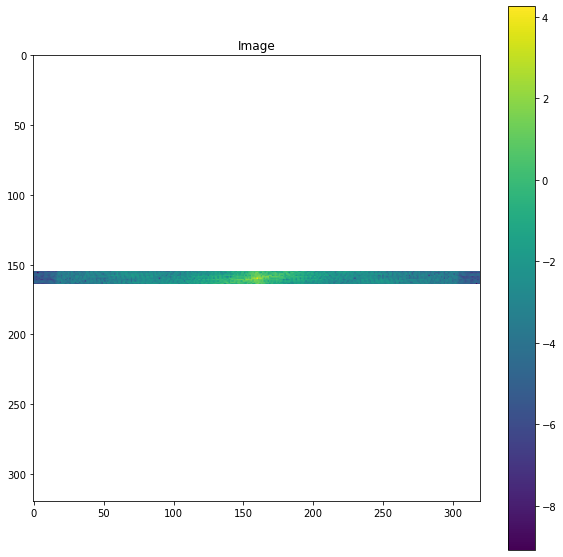

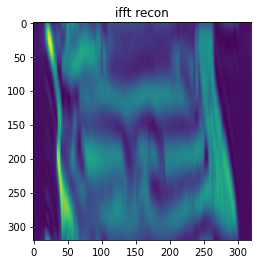

ifft relative l2 error =  0.21274244347767518


In [36]:
# multiple lambda values test

mask,_,_ = mask_naiveRand(heg,fix=10,other=0,roll=roll_flag)
mask = mask.numpy()
yraw = F.fftshift(F.fftn(img,norm='ortho'))
y    = np.zeros_like(yraw)
y[mask==1,:] = yraw[mask==1,:]

print('yshape = ',y.shape)
kplot(y,log=True)

x_ifft = np.abs(F.ifftn( F.fftshift(y),norm='ortho' ))
plt.figure()
plt.title('ifft recon')
plt.imshow(x_ifft)
plt.show()
err_ifft = np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
print('ifft relative l2 error = ',\
      np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

In [37]:
# Compressive Sensing reconstruction using Sigpy Package
l2loss = lambda x_recon,img: np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
ksp = y 
mps = np.ones((1,heg,wid))
# x_recon = np.fft.fftshift(np.real(TotalVariationRecon(ksp, mps, lamda, weights=mask).run()))
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda, weights=mask).run()))
nGrids = 13
lamda_grid = 10**(np.linspace(-3,-2,nGrids) ) # l1wavelet: -9,-8.5; tv: -6.5,-6.3
errors = np.zeros(nGrids)
ind = 0
for lamda in lamda_grid:
    print('iter {0} out of {1}'.format(ind+1,nGrids))
#     x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda).run()))
    x_recon    = F.fftshift( np.abs(TotalVariationRecon(ksp, mps, lamda,show_pbar=False).run()) )
    errors[ind] = l2loss(x_recon,img)
    ind += 1

iter 1 out of 13
iter 2 out of 13
iter 3 out of 13
iter 4 out of 13
iter 5 out of 13
iter 6 out of 13
iter 7 out of 13
iter 8 out of 13
iter 9 out of 13
iter 10 out of 13
iter 11 out of 13
iter 12 out of 13
iter 13 out of 13


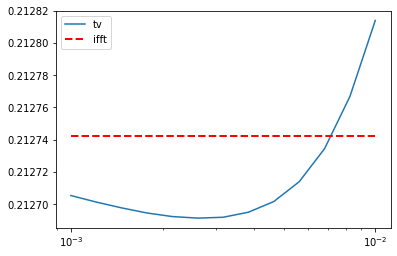

opt. pwr ind    =  5
opt. pwr        =  -2.5833333333333335
opt. Lambda val =  0.0026101572156825357


In [43]:
plt.figure()
plt.plot(lamda_grid,errors,label='tv')
plt.plot(lamda_grid,err_ifft*np.ones(errors.size),'r--', linewidth=2,label='ifft')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.show()
print('opt. pwr ind    = ',np.argmin(errors))
print('opt. pwr        = ',np.log10(lamda_grid[np.argmin(errors)]))
print('opt. Lambda val = ',lamda_grid[np.argmin(errors)])
# plt.figure()
# plt.imshow(x_recon)
# plt.show()
# print('Recon relative l2 error = ',\
#       np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

### Greedy mask select protocol

In [72]:
def greedy_mask_select(x_GT,\
                       nlines=40,init_lines=10,\
                       lamda=1e-3,\
                       max_iter=100,max_cg_iter=100,\
                       test=False):
    heg = x_GT.shape[0]; wid = x_GT.shape[1]
    mps = np.ones((1,heg,wid))
    if test:
        t0    = time.time()
#     mask  = np.zeros((heg,wid))   # Mask to be applied
    lines = np.full(heg, False)  # Lines to be included in mask
    
    # Initializing mask with few lines at the centre
    lines[int(np.ceil((heg-init_lines)/2)):int(np.ceil((heg+init_lines)/2))] = True
#     mask[lines] = True
    initial_estimate = np.zeros_like(x_GT)
    line_indices = err_var = iter_time = list([])
    yraw = F.fftshift(F.fftn(x_GT,norm='ortho'))    
    for i in range(0,nlines-init_lines): # Iterate over all lines
        err = np.full(heg,np.Inf)
        print(f'[{i+1}/{nlines-init_lines}]')
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            if test:
                t_i = time.time()
            lines[line] = True
            y = np.zeros_like(yraw)
            y[lines==True,:] = yraw[lines==True,:]
            y = np.reshape(y, (-1,heg,wid))
            x_recon = F.ifftshift( np.abs(\
              TotalVariationRecon(y, mps, lamda,show_pbar=False,max_iter=max_iter,max_cg_iter=max_cg_iter).run()) ) # Compressive Sensing reconstruction using Sigpy Package
#             error[ind]   = np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
            err[line] = np.linalg.norm(x_recon-x_GT,'fro')/np.linalg.norm(x_GT,'fro') # nRMSE
            lines[line] = False
#             if test:
#                 print(f'[{i+1}/{nlines-init_lines}] time elapsed for line {line}: {time.time()-t_i}')
            
        line_idx = np.argmin(err) # Finding line index with least error
#         mask[line_idx,:] = True # Including line in the mask
        lines[line_idx]  = True  # Turning the line ON so that it doesn't get counted again
                    
        line_indices.append(line_idx)
        err_var.append(np.min(err))
        if test:
            iter_time.append(time.time()-t0)
            print(f'[{i+1}/{nlines-init_lines}] added line index: {line_idx}, least error: {np.round(np.min(err),2)}, Time: {np.round(iter_time[i],2)} secs')
    if test:
        return lines, err_var, iter_time
    else:
        return lines

In [88]:
import time
lines, err_var, iter_time = greedy_mask_select(img,40,10,lamda=1e-3,max_iter=100,max_cg_iter=100,test=True)

[1/30]
[1/30] added line index: 154, least error: 0.2, Time: 154 secs
[2/30]


KeyboardInterrupt: 

In [75]:
import mask_backward_new
from mask_backward_new import mask_eval

In [85]:
mask = torch.tensor(lines).view(1,-1)
xstar = torch.tensor(img).view(1,img.shape[0],img.shape[1])
print('greedy  mask loss: ', mask_eval(mask,xstar,mode='sigpy',Lambda=1e-3))
randmask,_,_ = mask_naiveRand(heg,fix=40,other=0,roll=roll_flag)
print('lowfreq mask loss: ', mask_eval(randmask.view(1,-1),xstar,mode='sigpy',Lambda=1e-3))

greedy  mask loss:  0.087642452570043
lowfreq mask loss:  0.09047814191591573


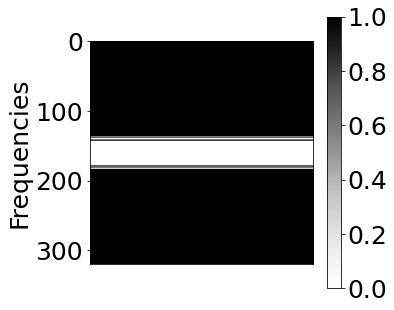

In [87]:
kplot(mask.view(-1))

#### Siddhant's code

In [2]:
def greedy_algorithm(y,x_GT,nlines,init_lines,mps,lamda,max_iter,metric):
    t0=time.time()
    N1=y.shape[0];N2=y.shape[1]
    mask=np.zeros((N1,N2)) # Mask to be applied
    lines=np.full(N1, False) # Lines to be included in mask
    
    # Initializing mask with few lines at the centre
    lines[int(N1/2-init_lines/2):int(N1/2+init_lines/2)]=True; mask[lines]=True
    initial_estimate=np.zeros_like(x_GT)
    line_indices=[]; err_var=[]; iter_time=[]
    
    for i in range(0,nlines-init_lines): # Iterate over all lines
        print('Iteration =',i)
        err=np.full(N1,np.Inf)
        
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            mask[line,:]=True
            ksp=np.moveaxis(y, -1, 0) # Rearranging axes: Loading k-space data in sigpy format
            # Compressive Sensing reconstruction using Sigpy Package
            x_recon=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run()

            # Performance metric:
            if metric=='SSIM':
                err[line] = -ssim(abs(x_GT), abs(x_recon), data_range=abs(x_GT).max() - abs(x_GT).min()) # SSIM
            elif metric=='MSE':
                err[line]=np.linalg.norm(x_recon-x_GT)/np.linalg.norm(x_GT) # nRMSE
            elif metric=='MAE':
                err[line]=np.mean(np.abs(x_recon-x_GT)) # MAE
            elif metric=='HFEN':
                LoG_GT=ndimage.gaussian_laplace(np.real(x_GT), sigma=1)+1j*\
                ndimage.gaussian_laplace(np.imag(x_GT), sigma=1)
                LoG_recon=ndimage.gaussian_laplace(np.real(x_recon), sigma=1)+\
                1j*ndimage.gaussian_laplace(np.imag(x_recon), sigma=1)
                err[line] = np.linalg.norm(log_recon-log_GT)/np.linalg.norm(log_GT) # HFEN
            mask[line,:]=False
            
        line_idx=np.argmin(err) # Finding line index with least error
        mask[line_idx,:]=True # Including line in the mask
        lines[line_idx]=True  # Turning the line ON so that it doesn't get counted again
        
        # Initial estimate for the next iteration
        initial_estimate=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run()
            
        line_indices.append(line_idx); err_var.append(np.min(err)); iter_time.append(time.time()-t0)
        print('#lines added:',np.int(np.sum(mask,axis=0)[0]),', line index:',line_idx,', least error:',\
              np.round(np.min(err),2),', Time:', np.round(iter_time[i],2), 'seconds.')
    return mask, line_indices, err_var, iter_time

In [3]:
def greedy_joint_dynamic(y_dynamic,x_GT_dynamic,nlines,init_lines,mps_dynamic,lamda,max_iter,metric):
    t0=time.time()
    N1=y_dynamic.shape[0];N2=y_dynamic.shape[1];
    N_frames=y_dynamic.shape[3]
    mask=np.zeros((N1,N2)) # Mask to be applied
    lines=np.full(N1, False) # Lines to be included in mask
    lines[int(N1/2-init_lines/2):int(N1/2+init_lines/2)]=True; 
    mask[lines]=True # Initializing mask with few lines at the centre
    initial_estimate=np.zeros((N1,N2),dtype='complex')
    
    line_indices=[]; err_var=[]; iter_time=[]
    for i in range(0,nlines-init_lines): # Iterate over all lines
        print('Iteration =',i)
        err=np.full(N1,np.Inf)
        
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            mask[line,:]=True
            err_fr=np.zeros((N_frames))
            for ph in range(0,N_frames):
                y=y_dynamic[:,:,:,ph]; x_GT=x_GT_dynamic[:,:,ph]; mps=mps_dynamic[:,:,:,ph]
                ksp=np.moveaxis(y, -1, 0) # Reaaranging axes: Loading k-space data in sigpy format
                x_recon=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run() # CS reconstruction
           
                # Performance metric:
                if metric=='SSIM':
                    err_fr[ph] = -ssim(abs(x_GT), abs(x_recon), data_range=abs(x_GT).max() - abs(x_GT).min()) # SSIM
                elif metric=='MSE':
                    err_fr[ph]=np.mean(np.abs(x_recon-x_GT)**2) # MSE
                elif metric=='MAE':
                    err_fr[ph]=np.mean(np.abs(x_recon-x_GT)) # MAE
                elif metric=='HFEN':
                    LoG_GT=ndimage.gaussian_laplace(np.real(x_GT), sigma=1)+1j*\
                    ndimage.gaussian_laplace(np.imag(x_GT), sigma=1)
                    LoG_recon=ndimage.gaussian_laplace(np.real(x_recon), sigma=1)+\
                    1j*ndimage.gaussian_laplace(np.imag(x_recon), sigma=1)
                    err_fr[ph] = np.linalg.norm(log_recon-log_GT)/np.linalg.norm(log_GT) # HFEN
                    
            mask[line,:]=False
            err[line]=np.mean(err_fr)
        line_idx=np.argmin(err) # Finding line index with least error
        mask[line_idx,:]=True # Including line in the mask
        lines[line_idx]=True  # Turning the line ON so that it doesn't get counted again
                
        line_indices.append(line_idx); err_var.append(np.min(err)); iter_time.append(time.time()-t0)
        np.savez('ocmr_sigpy_joint_dynamic',mask,line_indices,err_var,iter_time,i)
        print('#lines added =',np.sum(mask,axis=0)[0],', line index =',line_idx,', least error =',np.round(np.min(err),2),\
              ', Time=', np.round(iter_time[i],2), 'seconds.')
    return mask, line_indices, err_var, iter_time

### arxived reconstructor from class material

In [ ]:
import pywt
class Linop(object):
    def __call__(self, x):
        return self._forward(x)
    
    def H(self, x):
        return self._adjoint(x)
    
    def __mul__(self, B):
        return Compose(self, B)
    
    def _forward(self, x):
        raise NotImplementedError

    def _adjoint(self, x):
        raise NotImplementedError
        
class Compose(Linop):
    def __init__(self, A, B):
        self.A = A
        self.B = B
        
    def _forward(self, x):
        return self.A(self.B(x))
    
    def _adjoint(self, x):
        return self.B.H(self.A.H(x))
    
class FFTLinop(Linop):
    
    def _forward(self, x):
        y = np.fft.ifftshift(x)
        y = np.fft.fftn(y, norm='ortho')
        y = np.fft.fftshift(y)
        return y

    def _adjoint(self, x):
        y = np.fft.ifftshift(x)
        y = np.fft.ifftn(y, norm='ortho')
        y = np.fft.fftshift(y)
        return y

class SamplingLinop(Linop):

    def _forward(self, x):
        return mask * x

    _adjoint = _forward

class InverseWaveletLinop(Linop):

    def _forward(self, x):
        y = pywt.array_to_coeffs(x, coeff_slices)
        y = pywt.waverecn(y, 'db4', mode='periodic')
        return y

    def _adjoint(self, x):
        coeff = pywt.wavedecn(x, 'db4', mode='periodic', level=3)
        coeff, coeff_slices = pywt.coeffs_to_array(coeff)
        return coeff

def soft_thresh(z, lamda):
    mag = np.abs(z) - lamda
    mag *= mag > 0
    
    sign = np.divide(z, np.abs(z), where=np.abs(z) != 0)
    return mag * sign


max_iterations = 200  # number of iterations of proximal gradient descent
alpha = 1e-1 # 0.1    # step size
lamda = 5e-8 
def L1WaveletRecon(ksp,lamda=5e-8, alpha=1e-1, max_iter=200):
    F = FFTLinop()
    S = SamplingLinop()
    mask = np.abs(ksp) > 0
    W = InverseWaveletLinop()
    A = S * F * W
    coeff_hat = np.zeros_like(coeff).astype(ksp.dtype)  #initial sparse coefficients
    for it in range(max_iterations):
        coeff_hat -= alpha * A.H(A(coeff_hat) - ksp)
        coeff_hat = soft_thresh(coeff_hat, lamda * alpha)

    #How do you get the image from the reconstructed wavelet coefficients?
    img_hat = W(coeff_hat)

return img_hat

#### Enter Answer Below ####
fig, ax = plt.subplots()
ax.imshow(np.abs(img), cmap='gray')#, vmax=1)
ax.set_title('Ground Truth')

fig, ax = plt.subplots()
ax.imshow(np.abs(img_r), cmap='gray')#, vmax=1)
ax.set_title('Inverse FFT Reconstruction')

fig, ax = plt.subplots()
ax.imshow(np.abs(img_hat), cmap='gray')#, vmax=1)
ax.set_title('Wavelet Sparsity Regularized Reconstruction')

print('RMSE of the inverse FFT reconstruction is', RMSE(img_r,img), 'and the RMSE of the l1 reconstruction is', RMSE(img_hat,img))